In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import cmath
from datetime import datetime
from kneed import KneeLocator
from matplotlib import colors
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from neural_analysis.matIO import loadmat
from neural_analysis import spectra
from nolitsa import delay
import numpy as np
import os
import pandas as pd
import re
import scipy
from scipy.signal import butter, lfilter
from sklearn.decomposition import PCA
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.tsa.api import AutoReg, VAR
import sys
import time
from tqdm.auto import tqdm
import traceback as tb

plt.style.use('../../sci_style.py')

sys.path.append('../../..')
from iaaft import surrogates
from dynamical_systems_models import construct_dictionary, embed_signal, perform_stability_analysis, get_stability_results, compute_EDMD, predict_EDMD, compute_VAR_p, predict_VAR_p
from nld_utils import calculate_fnn_stat, get_nn_indices
from plot import plot_individual_areas, plot_multipopulation
from up_down import get_up_down
from utils import compute_summary_statistics, get_data_class, get_result_path, load, load_session_data, run_window_selection, save

# Load Neural Data 

In [3]:
session = 'Mary-Anesthesia-20160912-02'

In [4]:
all_data_dir = '/om/user/eisenaj/datasets/anesthesia/mat'
data_class = get_data_class(session, all_data_dir)

In [5]:
variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'unitInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, lfp, lfp_schema, session_info, spike_times, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['spikeTimes'], session_vars['unitInfo']

In [6]:
spike_times = spike_times[0]

# Delayed MI

In [10]:
# data = lfp[:int(session_info['drugStart'][0]/dt)]
# num_lags = 200

# delayed_mi = np.zeros((num_lags + 1, data.shape[1]))
# for i in tqdm(range(num_lags + 1)):
#     for j in range(data.shape[1]):
# #     for j in [0]:
#         delayed_mi[i, j] = delay.mi(data[:data.shape[0] - i:, j], data[i:, j], bins=64)

# pd.to_pickle(delayed_mi, 'delayed_mi_wake.pkl')

In [7]:
delayed_mi = pd.read_pickle('delayed_mi_wake.pkl')

In [8]:
def pick_tau(signal, method='knee'):
    if method == 'local_min':
        local_min_inds = scipy.signal.argrelextrema(signal, np.less)[0]
        if len(local_min_inds) == 0:
            tau = signal.argmin()
        else:
            tau = local_min_inds[0]
    else: # method == 'knee'
        kneedle = KneeLocator(np.arange(len(signal)), signal, S=1, curve='convex', direction='decreasing')
    
    return kneedle.knee

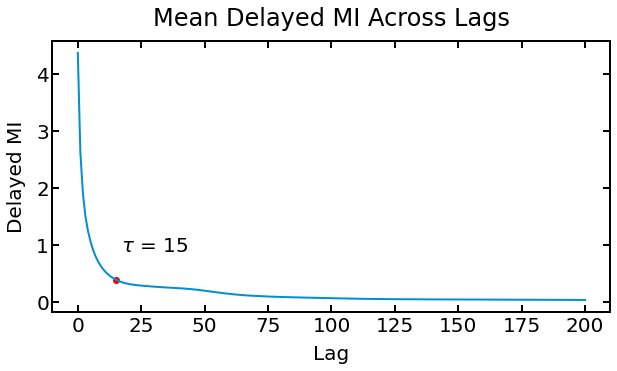

In [9]:
# dim = 23
# tau = pick_tau(delayed_mi[:, dim])
# plt.plot(delayed_mi[:, dim])
# plt.scatter(tau, delayed_mi[tau, dim], c='red')
# plt.xlabel('Lag')
# plt.ylabel('Delayed MI')
# plt.title(f'Delayed MI Dimension {dim}')
# plt.text(tau + 2, delayed_mi[tau, dim] + 0.5, fr"$\tau$ = {tau}")
# plt.show()

mean_delayed_mi = delayed_mi.mean(axis=1)
tau = pick_tau(mean_delayed_mi)

plt.plot(mean_delayed_mi)
plt.scatter(tau, mean_delayed_mi[tau], c='red')
plt.xlabel('Lag')
plt.ylabel('Delayed MI')
plt.title('Mean Delayed MI Across Lags')
plt.text(tau + 2, mean_delayed_mi[tau] + 0.5, fr"$\tau$ = {tau}")
plt.show()

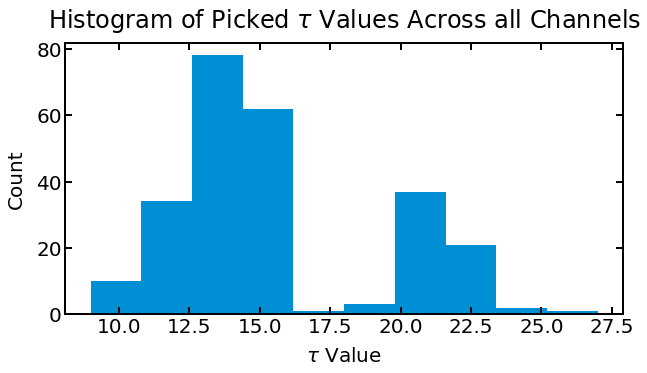

In [10]:
taus = []
for j in range(delayed_mi.shape[1]):
    taus.append(pick_tau(delayed_mi[:, j]))

plt.hist(taus)
plt.xlabel(r'$\tau$ Value')
plt.ylabel('Count')
plt.title(r'Histogram of Picked $\tau$ Values Across all Channels')
plt.show()

In [11]:
tau

15

In [271]:
tau = 15
# tau = 1
tau = 4
lfp_subsampled = lfp[np.arange(0, lfp.shape[0], tau)]

# Compute

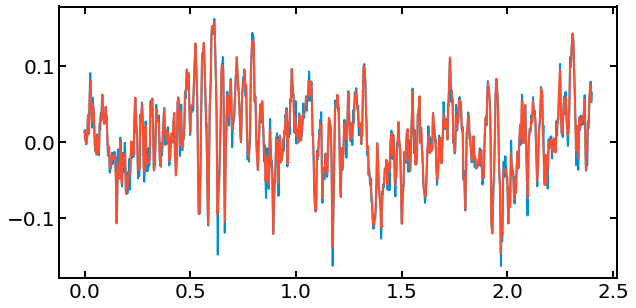

In [272]:
plt.plot(np.arange(600*dt*tau/dt)*dt, lfp[:int(600*dt*tau/dt), 0])
plt.plot(np.arange(600)*dt*tau, lfp_subsampled[:600, 0])
plt.show()

In [290]:
start = 1 # s
start = int(start/(dt*tau))
# window = 10000 # time steps
# window = int(10/(dt*tau)) # s

area = 'vlPFC'
if area == 'all':
    unit_indices = np.arange(len(electrode_info['area']))
else:
    unit_indices = np.where(electrode_info['area'] == area)[0]

window = 8000
window_data = lfp_subsampled[start:start + window, unit_indices]

# test_start = start + window
# test_time = int(session_info['drugStart'][0])*1000 - window - start

# test_time = int(30/(dt*tau))
# test_start = int(session_info['drugStart'][0]/(dt*tau)) - int(120/(dt*tau)) - test_time

test_start = start + window
test_time = 5000

p = 15
test_data = lfp_subsampled[test_start - p:test_start + test_time, unit_indices]

In [291]:
surrogate_window_length = int(200/(dt*tau)) # time steps

window_data_surrogate = np.zeros(window_data.shape)
for i in tqdm(range(window_data.shape[1])):
#     window_data_surrogate[:, i] = surrogates(window_data[:, i], 1, verbose=False)
    surr = surrogates(lfp_subsampled[start:start + surrogate_window_length, i], 1, verbose=False)[0]
    window_data_surrogate[:, i] = surr[:window]

test_data_surrogate = np.zeros(test_data.shape)
for i in tqdm(range(test_data.shape[1])):
#     test_data_surrogate[:, i] = surrogates(test_data[:, i], 1, verbose=False)
    surr = surrogates(lfp_subsampled[test_start - p:test_start + surrogate_window_length, i], 1, verbose=False)[0]
    test_data_surrogate[:, i] = surr[:test_time + p]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

In [292]:
# pd.to_pickle(window_data_surrogate, 'window_data_surrogate_wake_tau_15.pkl')
# pd.to_pickle(test_data_surrogate, 'test_data_surrogate_wake_tau_15.pkl')

# window_data_surrogate = pd.read_pickle('window_data_surrogate_wake.pkl')
# test_data_surrogate = pd.read_pickle('test_data_surrogate_wake.pkl')

In [293]:
if window_data.shape[0] < window_data.shape[1]*p:
    raise ValueError(f"Overdetermined!! {window_data.shape[0]} time steps and {p}*{window_data.shape[1]} = {p*window_data.shape[1]} dimensions")

In [294]:
normalize = False
lamb = 0
print("ORIGINAL")
results = compute_VAR_p(window_data, p, normalize=normalize, lamb=lamb)
print("SURROGATE")
results_surrogate = compute_VAR_p(window_data_surrogate, p, normalize=normalize, lamb=lamb)

ORIGINAL
SURROGATE


In [295]:
window_data.shape

(8000, 64)

In [296]:
train_true_vals.shape

(7985, 64)

In [297]:
print("ORIGINAL")
train_preds, train_true_vals, train_pb_mse, train_pb = predict_VAR_p(window_data, results['coefs'], results['intercept'], persistence_baseline=2, normalize=normalize)
print("SURROGATE")
train_preds_surrogate, train_true_vals_surrogate, train_pb_mse_surrogate, train_pb_surrogate = predict_VAR_p(window_data_surrogate, results_surrogate['coefs'], results_surrogate['intercept'], persistence_baseline=2, normalize=normalize)
print("ORIGINAL ON SURROGATE")
train_preds_O2S, train_true_vals_O2S, train_pb_mse_O2S, train_pb_O2S = predict_VAR_p(window_data_surrogate, results['coefs'], results['intercept'], persistence_baseline=2, normalize=normalize)
print("SURROGATE ON ORIGINAL")
train_preds_S2O, train_true_vals_S2O, train_pb_mse_S2O, train_pb_S2O = predict_VAR_p(window_data, results_surrogate['coefs'], results_surrogate['intercept'], persistence_baseline=2, normalize=normalize)

ORIGINAL
SURROGATE
ORIGINAL ON SURROGATE
SURROGATE ON ORIGINAL


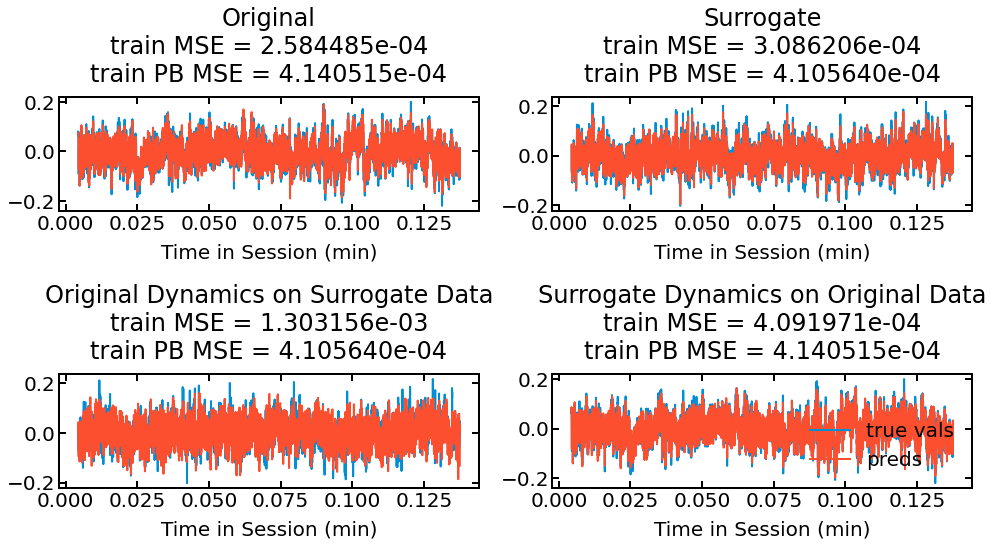

In [298]:
fig, axs = plt.subplots(2, 2, figsize=(14, 8))
time_vals = np.arange(start + p, start + window)/(1000*60)

ax = axs[0][0]
train_mse = ((train_preds - train_true_vals)**2).mean()
ax.plot(time_vals, train_true_vals[:, 0], label='true vals')
ax.plot(time_vals, train_preds[:, 0], label='preds')
ax.set_xlabel('Time in Session (min)')
ax.set_title(f"Original\ntrain MSE = {train_mse:3e}\ntrain PB MSE = {train_pb_mse:3e}")

ax = axs[0][1]
train_mse_surrogate = ((train_preds_surrogate - train_true_vals_surrogate)**2).mean()
ax.plot(time_vals, train_true_vals_surrogate[:, 0], label='true vals')
ax.plot(time_vals, train_preds_surrogate[:, 0], label='preds')
ax.set_xlabel('Time in Session (min)')
ax.set_title(f"Surrogate\ntrain MSE = {train_mse_surrogate:3e}\ntrain PB MSE = {train_pb_mse_surrogate:3e}")

ax = axs[1][0]
train_mse_O2S = ((train_preds_O2S - train_true_vals_O2S)**2).mean()
ax.plot(time_vals, train_true_vals_O2S[:, 0], label='true vals')
ax.plot(time_vals, train_preds_O2S[:, 0], label='preds')
ax.set_xlabel('Time in Session (min)')
ax.set_title(f"Original Dynamics on Surrogate Data\ntrain MSE = {train_mse_O2S:3e}\ntrain PB MSE = {train_pb_mse_O2S:3e}")

ax = axs[1][1]
train_mse_S2O = ((train_preds_S2O - train_true_vals_S2O)**2).mean()
ax.plot(time_vals, train_true_vals_S2O[:, 0], label='true vals')
ax.plot(time_vals, train_preds_S2O[:, 0], label='preds')
ax.legend()
ax.set_xlabel('Time in Session (min)')
ax.set_title(f"Surrogate Dynamics on Original Data\ntrain MSE = {train_mse_S2O:3e}\ntrain PB MSE = {train_pb_mse_S2O:3e}")

# ax.set_xlim([time_vals[0], time_vals[100]])

plt.tight_layout()
plt.show()

In [299]:
T_pred = 100

In [300]:
tail_bite = False
test_preds, test_true_vals, test_pb_mse, test_pb = predict_VAR_p(test_data[:p + T_pred], results['coefs'], results['intercept'], persistence_baseline=2, tail_bite=tail_bite, normalize=normalize)
test_preds_surrogate, test_true_vals_surrogate, test_pb_mse_surrogate, test_pb_surrogate = predict_VAR_p(test_data_surrogate[:p + T_pred], results_surrogate['coefs'], results_surrogate['intercept'], persistence_baseline=2, tail_bite=tail_bite, normalize=normalize)
test_preds_O2S, test_true_vals_O2S, test_pb_mse_O2S, test_pb_O2S = predict_VAR_p(test_data_surrogate[:p + T_pred], results['coefs'], results['intercept'], persistence_baseline=2, tail_bite=tail_bite, normalize=normalize)
test_preds_S2O, test_true_vals_S2O, test_pb_mse_S2O, test_pb_S2O = predict_VAR_p(test_data[:p + T_pred], results_surrogate['coefs'], results_surrogate['intercept'], persistence_baseline=2, tail_bite=tail_bite, normalize=normalize)

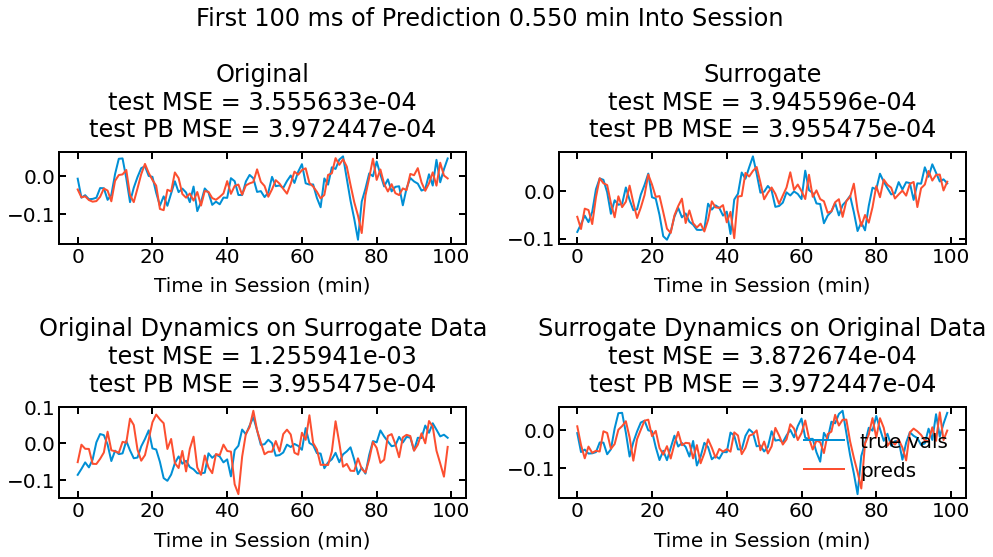

In [301]:
display_time = T_pred
location = 'First'
if location == 'Final':
    display_start = test_preds.shape[0] - display_time
    display_end = test_preds.shape[0]
    time_vals = np.arange(-display_time, 0)
else: # location == 'First'
    display_start = 0
    display_end = display_time
    time_vals = np.arange(display_time)
    
fig, axs = plt.subplots(2, 2, figsize=(14, 8))

plt.suptitle(f'{location} {display_time} ms of Prediction {test_start*dt*tau/(60):.3f} min Into Session')

ax = axs[0][0]
test_mse = ((test_preds - test_true_vals)**2).mean()
ax.plot(time_vals, test_true_vals[display_start:display_end, 0], label='true vals')
ax.plot(time_vals, test_preds[display_start:display_end, 0], label='preds')

ax.set_xlabel('Time in Session (min)')
ax.set_title(f"Original\ntest MSE = {test_mse:3e}\ntest PB MSE = {test_pb_mse:3e}")

ax = axs[0][1]
test_mse_surrogate = ((test_preds_surrogate - test_true_vals_surrogate)**2).mean()
ax.plot(time_vals, test_true_vals_surrogate[display_start:display_end, 0], label='true vals')
ax.plot(time_vals, test_preds_surrogate[display_start:display_end, 0], label='preds')

ax.set_xlabel('Time in Session (min)')
ax.set_title(f"Surrogate\ntest MSE = {test_mse_surrogate:3e}\ntest PB MSE = {test_pb_mse_surrogate:3e}")

ax = axs[1][0]
test_mse_O2S = ((test_preds_O2S - test_true_vals_O2S)**2).mean()
ax.plot(time_vals, test_true_vals_O2S[display_start:display_end, 0], label='true vals')
ax.plot(time_vals, test_preds_O2S[display_start:display_end, 0], label='preds')

ax.set_xlabel('Time in Session (min)')
ax.set_title(f"Original Dynamics on Surrogate Data\ntest MSE = {test_mse_O2S:3e}\ntest PB MSE = {test_pb_mse_O2S:3e}")

ax = axs[1][1]
test_mse_S2O = ((test_preds_S2O - test_true_vals_S2O)**2).mean()
ax.plot(time_vals, test_true_vals_S2O[display_start:display_end, 0], label='true vals')
ax.plot(time_vals, test_preds_S2O[display_start:display_end, 0], label='preds')
ax.legend()
ax.set_xlabel('Time in Session (min)')
ax.set_title(f"Surrogate Dynamics on Original Data\ntest MSE = {test_mse_S2O:3e}\ntest PB MSE = {test_pb_mse_S2O:3e}")

plt.tight_layout()
plt.show()

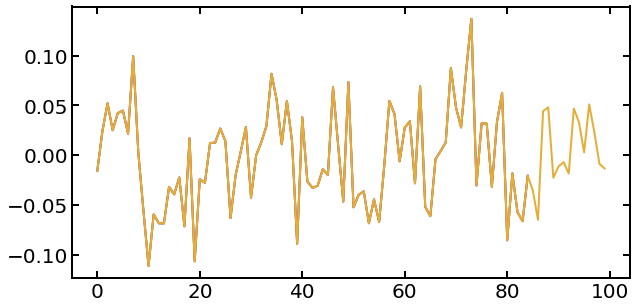

In [259]:
plt.plot(train_true_vals[:85, 0])
plt.plot(window_data[15:100, 0])
plt.plot(lfp_subsampled[start + p:start + p + 100, 0])

In [260]:
window_data_emb = embed_signal(window_data, p, 1, direction='reverse')
window_data_surrogate_emb = embed_signal(window_data_surrogate, p, 1, direction='reverse')

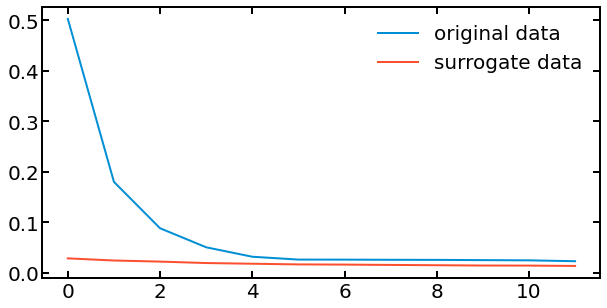

In [261]:
pca_original = PCA(n_components=12)
wd_pca = pca_original.fit_transform(window_data_emb)

pca_surrogate = PCA(n_components=12)
wd_surr_pca = pca_surrogate.fit_transform(window_data_surrogate_emb)
plt.plot(pca_original.explained_variance_, label='original data')
plt.plot(pca_surrogate.explained_variance_, label='surrogate data')
plt.legend()

In [168]:
wd_pca.shape

(7986, 12)

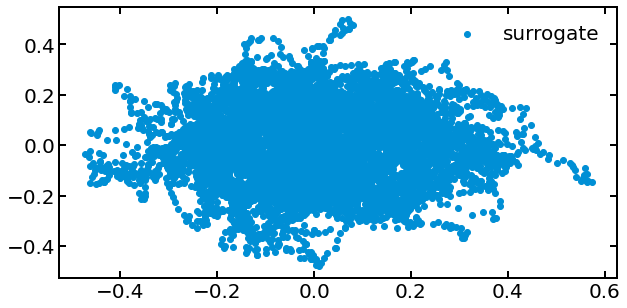

In [262]:
# plt.scatter(wd_pca[:, 0], wd_pca[:, 1], label='original')
plt.scatter(wd_surr_pca[:, 0], wd_surr_pca[:, 1], label='surrogate')
plt.legend()

In [263]:
_, S, _ = np.linalg.svd(window_data_emb)

In [264]:
_, S_surr, _ = np.linalg.svd(window_data_surrogate_emb)

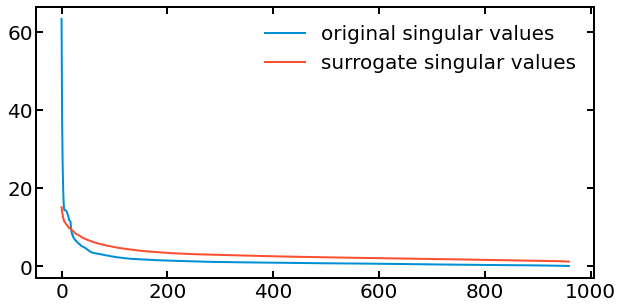

In [265]:
plt.plot(S, label='original singular values')
plt.plot(S_surr, label='surrogate singular values')
# plt.xlim([0, 200])
plt.legend()
plt.show()

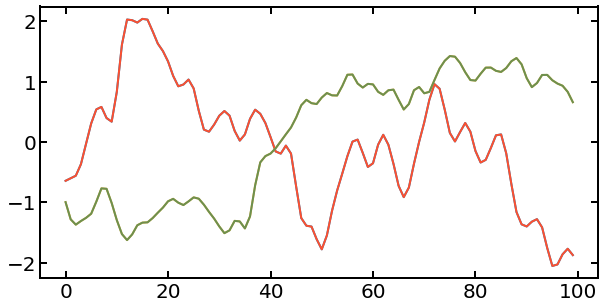

In [83]:
plt.plot(test_true_vals_surrogate[:, 0])
plt.plot(test_true_vals_O2S[:, 0])
plt.plot(test_true_vals[:, 0])
plt.plot(test_true_vals_S2O[:, 0])

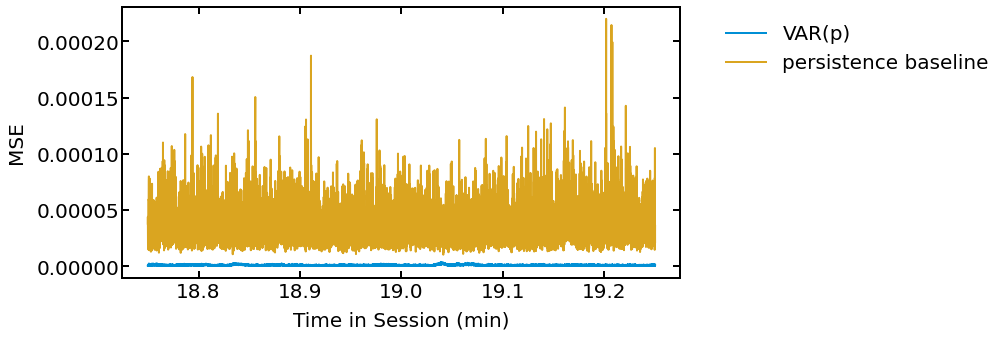

In [63]:
# time_vals = np.arange(test_time)/(1000*60)
time_vals = np.arange(test_start, test_start + test_time)/(1000*60)
plt.plot(time_vals, ((test_preds - test_true_vals)**2).mean(axis=1), label='VAR(p)')
plt.plot(time_vals, ((test_pb - test_true_vals)**2).mean(axis=1), c='goldenrod', label='persistence baseline')
plt.xlabel('Time in Session (min)')
plt.ylabel('MSE')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [47]:
test_pred_mse_over_time = ((test_preds - test_true_vals)**2).mean(axis=1)
test_pb_mse_over_time = ((test_pb - test_true_vals)**2).mean(axis=1)

In [48]:
np.sum(test_pred_mse_over_time > test_pb_mse_over_time)/len(test_pred_mse_over_time)

0.0

In [51]:
np.sum(test_pred_mse_over_time > test_pb_mse_over_time), len(test_pred_mse_over_time)

(0, 30000)

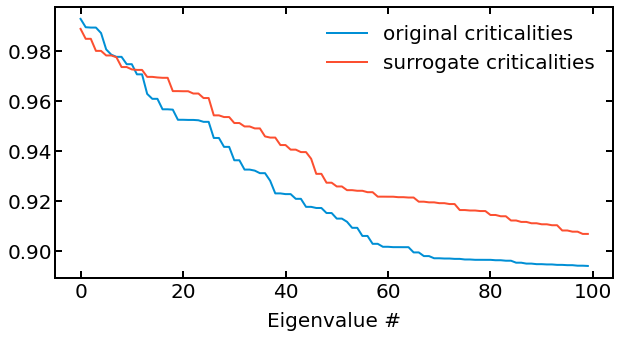

In [302]:
end = 100
plt.plot(results['criticality_inds'][:end], label='original criticalities')
plt.plot(results_surrogate['criticality_inds'][:end], label='surrogate criticalities')
plt.xlabel('Eigenvalue #')
plt.legend()
plt.show()

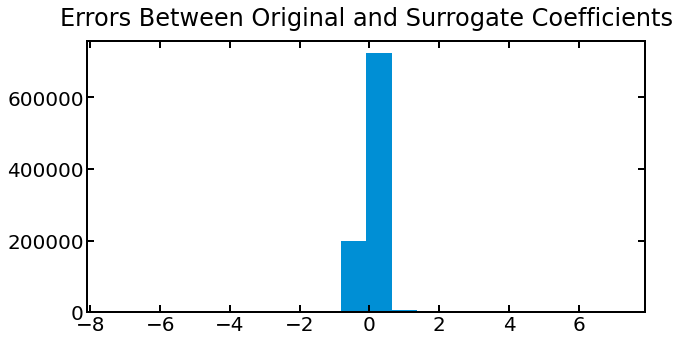

In [84]:
plt.hist((results['coefs'] - results_surrogate['coefs']).flatten(), bins=20)
plt.title('Errors Between Original and Surrogate Coefficients')
plt.show()